# Part a
This notebook contains a step-by-step walkthrough of task a) using both code and text.

In [1]:
%load_ext autoreload
%autoreload 2
#Add own modules to path
import sys
sys.path.append('../..')
sys.path.append('../../src/')

### Loading the data and constructing the design matrix
In this part the terrain data used in previous project will be used again. 100x100 data points is extracted from the data. In this project, the extracted image will instead be downsampled, i.e every 40th data point is used as to provide the models less data. This allows analyses that is more likely to reveal some of the parameters/conditions effects on the result.

For simplicity one function has been created and is used to load and downsample the data, and create the design matrix. From project 1 it was concluded that an OLS model with a polynomial design matrix of degree 30 provided sufficiently good results. However, we will in this case produce new results with the downsampled data, though only for OLS and Ridge. The complexity found then, will be used further when analyzing SGD regression.

In [2]:
from src.data.create_dataset import create_dataset
X, z = create_dataset('../../data/raw/SRTM_data_Norway_1.tif',N=100,downsampling=8) 

### Plotting the data

../..\src\visualization\visualize.py:46: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Test data'}, xlabel='X', ylabel='Y'>

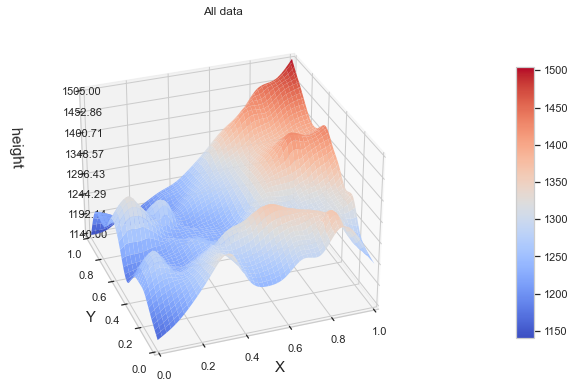

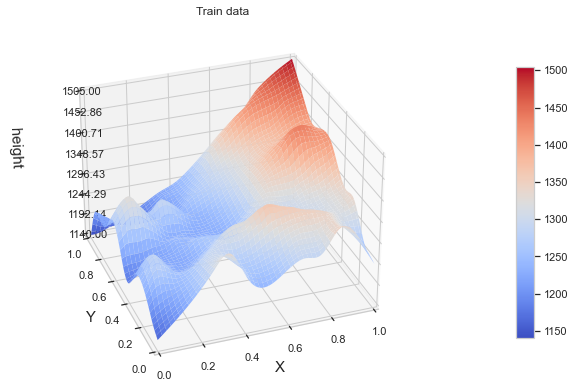

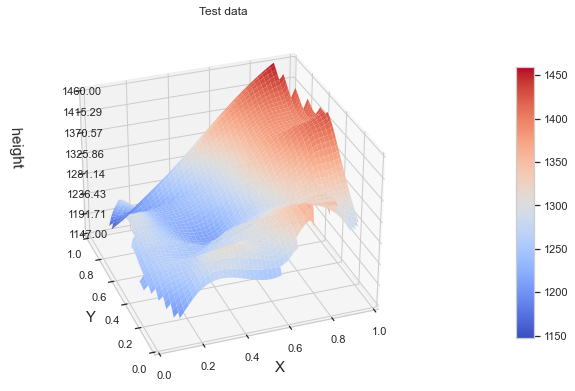

In [3]:
from src.visualization.visualize import plot_surf_from_X
from sklearn.model_selection import  train_test_split
import seaborn as sns
sns.set_theme(style='whitegrid')

X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)

plot_surf_from_X(X,z,'All data')
plot_surf_from_X(X_train,z_train,'Train data')
plot_surf_from_X(X_test,z_test,'Test data')

Above plots shows z, z_train and z_test plotted on a 2 by 2 grid spanning 0 to 1. Cubic interpolation is used to fill in the blanks, but some are not possible to interpolate to because they lie outside the convex hull of the data, meaning there's no data point on the other side to use in interpolation. This is clear from some of the rugged edges of train and test plots.

Anyhow, interpolation enables us to plot a smooth surface containing the predicted values of our future model.

### Scaling the data
The data is scaled using SKlearn's StandardScaler. Here standardization is used by subtracting the mean and dividing by std. The reason is that it helps the stochastic gradient descent algorithm converge faster, as it reduces the amount of steps needed to reach a good or optimal solution. This is because when standardizing there are less ravines(i.e mixture of steep and flat directions), which an sgd algorithm doesn't tend to handle very well. A steep hill will cause a big gradient that may in turn cause the sgd to overshoot at the next step. Standardizing ensures the parameter space is homogenous(i.e error ellipsis shown in image is more circular).

![standardization](../../figures/standardization_sgd.PNG)

(source: <i>Python Machine Learning - Second Edition</i>, by Sebastian Raschka & Vahid Mirjalili)

This is an argument for scaling the features, X and not the target data, z. However, as we will see later when fitting neural networks, high values of z can lead to initial errors being large which again may cause exploding gradients.

../..\src\visualization\visualize.py:46: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Scaled test data'}, xlabel='X', ylabel='Y'>

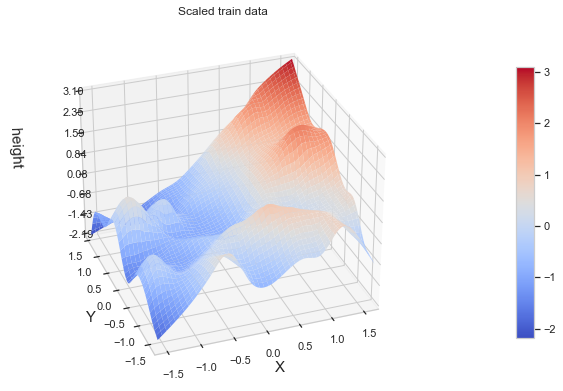

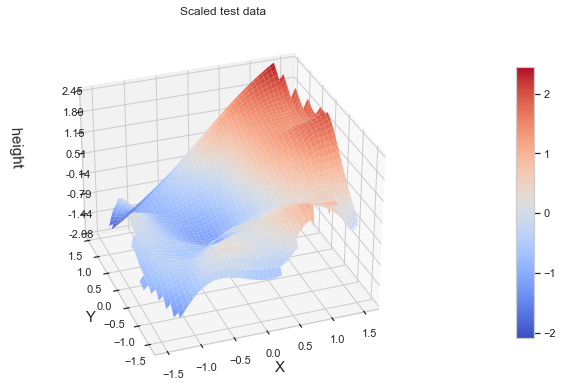

In [4]:
from sklearn.preprocessing import StandardScaler
X_scl = StandardScaler().fit(X_train)
z_scl = StandardScaler().fit(z_train)

X_train_scl = X_scl.transform(X_train)
X_test_scl = X_scl.transform(X_test)
z_train_scl = z_scl.transform(z_train)
z_test_scl = z_scl.transform(z_test)
plot_surf_from_X(X_train_scl,z_train_scl,'Scaled train data')
plot_surf_from_X(X_test_scl,z_test_scl,'Scaled test data')

### Revisiting regular OLS and Ridge
OLS and Ridge using matrix inversion was studied in former project, but will be presented here to provide basis for comparison. Note that a min max scaler was employed on the target data, but standardization is used in this case. As such, results from project 1 is not directly comparable, and so new OLS results will be generated using standard scaler here. 

As the squared erro cost function is convex, any local minima is the a global minima. As such, a solution using sgd will converge towards the analytical solution(i.e the optimal solution) with enough iterations and low enough learning rate.

Note that when training a linear regression model to produce a surface, it is fitted only once. But, when benchmarking and acquiring a score, crossvalidation is employed.

### Finding adequate model complexity
The polynomial degree that provides sufficient parameters without causing overfit can be found by crossvalidating the score at each degree. However, a bias-variance analysis using bootstrap can also be employed to detect where the region of overfit starts.
#### Bias variance OLS

<AxesSubplot:title={'center':'Cross validation'}, xlabel='Polynomial degree', ylabel='MSE'>

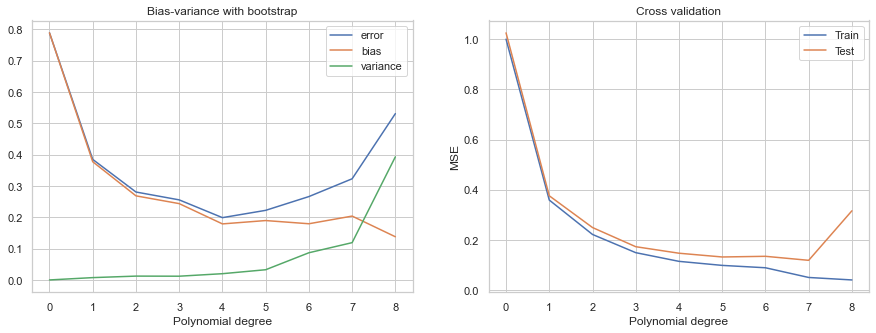

In [5]:
from src.modelling.linreg import LinReg
import numpy as np
from src.model_evaluation.resampling import cross_val_score, bias_var
from src.data.create_dataset import create_poly_design_matrix
from src.visualization.visualize import plot_curves
import matplotlib.pyplot as plt
#X, z = create_dataset('../../data/raw/SRTM_data_Norway_1.tif',N=100,downsampling=8) 

max_degree = 9
degrees_arr = np.arange(max_degree)
#For bootstrap and bias-var
n_bootstraps = 200
error = np.zeros(max_degree)
bias = np.zeros(max_degree)
variance = np.zeros(max_degree)
#bi_var = {'error':error,'bias':bias,'variance':variance}
#For cv
train_error = np.zeros(max_degree)
test_error = np.zeros(max_degree)

for deg in range(max_degree):
    X_mat = create_poly_design_matrix(X,degree=deg)
    X_train, X_test, z_train, z_test = train_test_split(X_mat,z, test_size=0.2,random_state=1)
    X_scl = StandardScaler().fit(X_train)
    z_scl = StandardScaler().fit(z_train)
    X_train = X_scl.transform(X_train)
    X_test = X_scl.transform(X_test)
    z_train = z_scl.transform(z_train)
    z_test = z_scl.transform(z_test)
    
    ols =LinReg(regularization = None)
    cv_scores = cross_val_score(ols,X_mat,z,10,X_scl,z_scl,metrics=['MSE'])
    train_error[deg] = cv_scores['train']['MSE']
    test_error[deg] = cv_scores['test']['MSE']    
    error[deg], bias[deg], variance[deg] = bias_var(ols, 
                                                    X_train, 
                                                    X_test, 
                                                    z_train,
                                                    z_test,
                                                    n_bootstraps=n_bootstraps)
    
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
plot_curves({'error':error,'bias':bias,'variance':variance},degrees_arr,
            ('Polynomial degree',''),title='Bias-variance with bootstrap',ax=ax1)
plot_curves({'Train':train_error,'Test':test_error},degrees_arr,
            ('Polynomial degree','MSE'),title='Cross validation',ax=ax2)

From the bias-variance analysis it can be seen that the error starts increasing after about degree 4. After degree 7 the variance has surpassed the bias causing a rapid growth in error. From the cv result it can be seen that the test score starts increasing after degree 5, however remains close to constant from degree 4 to 8.
This might indicate that degree 4 or 5 is perhaps the right choice for OLS.
#### Bias variance Ridge

<AxesSubplot:title={'center':'Cross validation'}, xlabel='Polynomial degree', ylabel='MSE'>

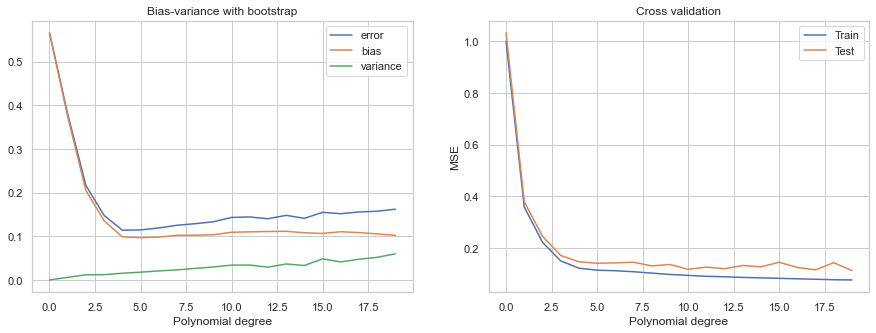

In [6]:
max_degree = 20
degrees_arr = np.arange(max_degree)
lmb = 0.01
#For bootstrap and bias-var
n_bootstraps = 200
error = np.zeros(max_degree)
bias = np.zeros(max_degree)
variance = np.zeros(max_degree)
#bi_var = {'error':error,'bias':bias,'variance':variance}
#For cv
train_error = np.zeros(max_degree)
test_error = np.zeros(max_degree)

for deg in range(max_degree):
    X_mat = create_poly_design_matrix(X,degree=deg)
    X_train, X_test, z_train, z_test = train_test_split(X_mat,z, test_size=0.2,random_state=42)
    X_scl = StandardScaler().fit(X_train)
    z_scl = StandardScaler().fit(z_train)
    X_train = X_scl.transform(X_train)
    X_test = X_scl.transform(X_test)
    z_train = z_scl.transform(z_train)
    z_test = z_scl.transform(z_test)
    
    ridge =LinReg(regularization = 'l2',lmb=lmb)
    cv_scores = cross_val_score(ridge,X_mat,z,10,X_scl,z_scl,metrics=['MSE'])
    train_error[deg] = cv_scores['train']['MSE']
    test_error[deg] = cv_scores['test']['MSE']    
    error[deg], bias[deg], variance[deg] = bias_var(ridge, 
                                                    X_train, 
                                                    X_test, 
                                                    z_train,
                                                    z_test,
                                                    n_bootstraps=n_bootstraps)
    
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
plot_curves({'error':error,'bias':bias,'variance':variance},degrees_arr,
            ('Polynomial degree',''),title='Bias-variance with bootstrap',ax=ax1)
plot_curves({'Train':train_error,'Test':test_error},degrees_arr,
            ('Polynomial degree','MSE'),title='Cross validation',ax=ax2)

It is clear that Ridge is more reistant to overfit. It seems it can have substantially higher complexities without getting majorly overfit. In the bias-variance analysis it reaches it best fit at around degree 5, after which the error starts increasing slowly. From the cross-validation degree 18 yielded the best result, though only by a small margin. It seems that Ridge somewhat stagnates, and it does so at about degree 5.

Henceforth a degree of 5 will be used for both Ridge and OLS.

../..\src\visualization\visualize.py:46: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


<Axes3DSubplot:title={'center':'Scaled surface - test data'}, xlabel='X', ylabel='Y'>

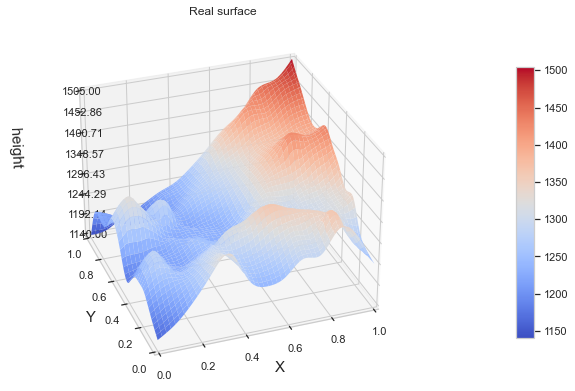

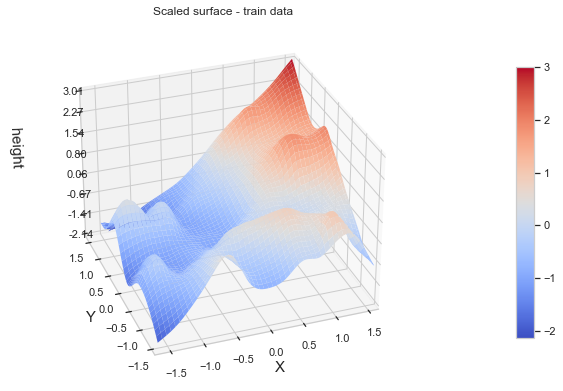

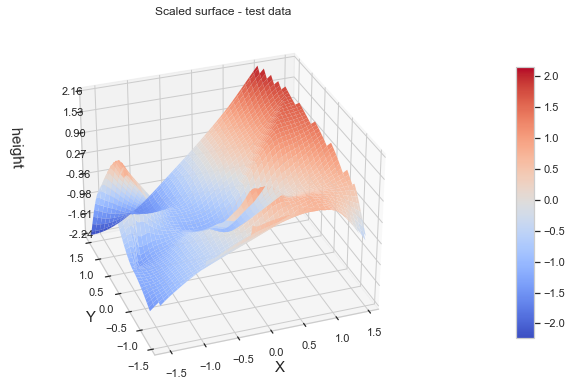

In [7]:
X, z = create_dataset('../../data/raw/SRTM_data_Norway_1.tif',N=100,degree=5,downsampling=8)
plot_surf_from_X(X,z,'Real surface')
X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)

X_scl = StandardScaler().fit(X_train)
z_scl = StandardScaler().fit(z_train)
X_train = X_scl.transform(X_train)
X_test = X_scl.transform(X_test)
z_train = z_scl.transform(z_train)
z_test = z_scl.transform(z_test)

plot_surf_from_X(X_train,z_train,'Scaled surface - train data')
plot_surf_from_X(X_test,z_test,'Scaled surface - test data')

Note that the view is rotated 250 degrees to provide a better viewing angle.

#### Optimal lambda
When tuning lambda to yield the optimal fit, one should avoid using the test set as this might yield deceptive final results. In other words, if optimizing lambda for test set, the model becomes biased, and might be unable to predict new data beyond the test set. As such, a third set should be employed for this, namely a validation set.

When evaluating the different lambda values, a cross-validation is used. Here the data is split into train and test. By providing this function with only the train data as opposed to the whole data set, we are effectivly creating a third validation set within the cv for parameter tuning. Finally one may benchmark the model using test data. 

Optimal lambda:  0.0001


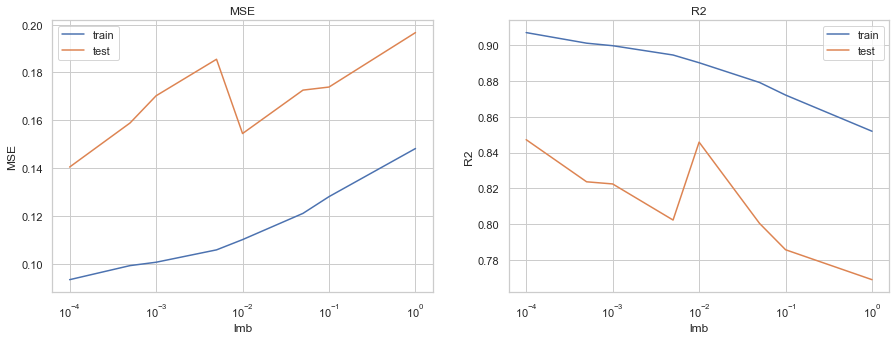

In [8]:
from src.model_evaluation.param_analysis import evaluate_parameter
from src.visualization.visualize import plot_curves

lambdas = np.array([0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,1])

ridge = LinReg(regularization='l2')
scores = evaluate_parameter(ridge,{'lmb':lambdas},['MSE','R2'],X_train,z_train,X_scl,z_scl)


fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(15,5)
plot_curves(scores['MSE'],lambdas,('lmb','MSE'),ax = ax1, title='MSE',x_axis='semilog')
plot_curves(scores['R2'],lambdas,('lmb','R2'),ax = ax2, title='R2',x_axis='semilog')
print('Optimal lambda: ',lambdas[np.argmin(scores['MSE']['test'])])

The optimal lambda found for degree 5 is 0.01. This will be used further in initial studies.
#### Cross validating OLS

../..\src\visualization\visualize.py:46: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(xi, yi, zi, cmap=cm.coolwarm,


OLS train[MSE,R2]: (0.09517788080417426, 0.9048221191958257) 
OLS test[MSE,R2]: (0.1669609140925199, 0.8252217700643927)
Ridge train[MSE,R2]: (0.11290337954039709, 0.8870966204596028) 
Ridge test[MSE,R2]: (0.14382738900570646, 0.8421857831008517)


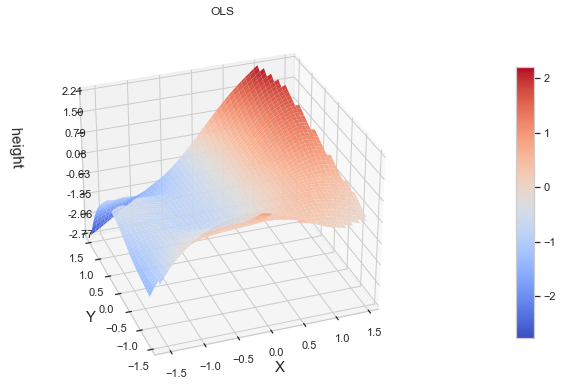

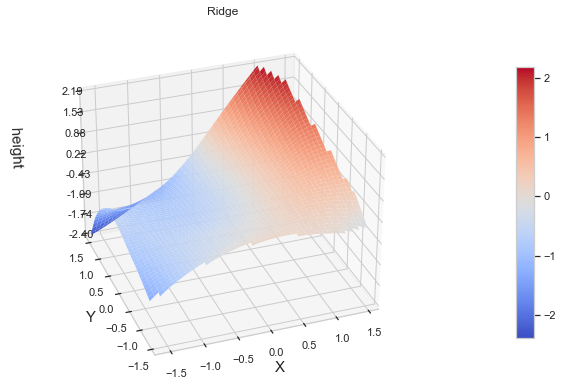

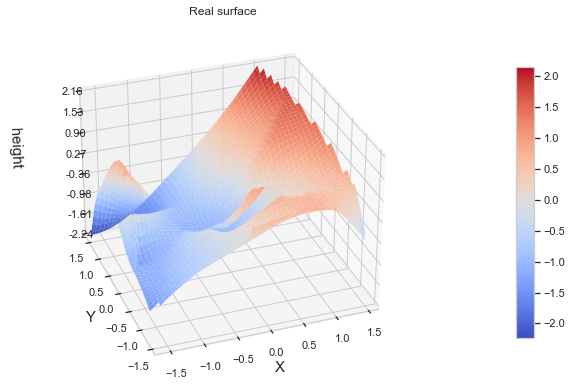

In [9]:
from src.model_evaluation.metrics import MSE_R2
from src.model_evaluation.resampling import cross_val_score

#Train the models
ols.fit(X_train,z_train)

ridge.set_params(lmb=0.01)
ridge.fit(X_train,z_train)
#Predict test and train to plot surface
z_tilde_ols = ols.predict(X_train)
z_pred_ols = ols.predict(X_test)
z_tilde_ridge = ridge.predict(X_train)
z_pred_ridge = ridge.predict(X_test)
#Concatenating X_train and X_test so that we 
#can plot the whole predicted surface
X_ = np.concatenate((X_train,X_test))


#Plot surface
#plot_surf_from_X(X_,np.concatenate((z_tilde_ols,z_pred_ols)),'OLS')
#plot_surf_from_X(X_,np.concatenate((z_tilde_ridge,z_pred_ridge)),'Ridge')
plot_surf_from_X(X_test,z_pred_ols,'OLS')
plot_surf_from_X(X_test,z_pred_ridge,'Ridge')
plot_surf_from_X(X_test,z_test,'Real surface')


#Cross validate the model scores
ols_scores =  cross_val_score(ols,X,z,5,X_scl,z_scl,['MSE','R2'])
ridge_scores =  cross_val_score(ridge,X,z,5,X_scl,z_scl,['MSE','R2'])
#Printing the scores
print('OLS train[MSE,R2]:',(ols_scores['train']['MSE'], ols_scores['train']['R2']), '\nOLS test[MSE,R2]:',(ols_scores['test']['MSE'], ols_scores['test']['R2']))
print('Ridge train[MSE,R2]:',(ridge_scores['train']['MSE'], ridge_scores['train']['R2']), '\nRidge test[MSE,R2]:',(ridge_scores['test']['MSE'], ridge_scores['test']['R2']))

The scores indicate a somewhat good fit. The MSE is low in both cases, the scale is also quite low, however we also see that the R2 score is somewhat high. OLS has a relatively high discrepancy between train and test score. Ridge scores better on the test data than OLS, which might indicate that it's better at generalizing. From the looks of it, the surfaces generated by OLS and Ridge are capturing the rough trends in the landscape, however not fully capturing the details.

### Regression using stochastic gradient descent
In place of matrix inversion when fitting parameters, we will in this case use sgd optimization.
To begin with, some parameters are set rather arbitrarily. Batch_size is 64 as a multiplum of 2 often enables more efficient vectorized calculations. The number of epochs are set to 100, which is low but demonstrates how sgd needs certain amounts of epochs to converge. Learning rate is set to 0.01, and when using regularization, lmb is set to 0.01. 

The polynomial degree of the design matrix is set to 5 as it proved to be the best fit for regression. Note again that for robust benchmarking of models, cross validation should be used, however, the initial objective here is to study the effects of the different parameters has on techniques surrounding sgd and how it converges and so cv will not be used yet.

OLS train[MSE,R2]: (0.09518524048013394, 0.904814759519866) 
OLS test[MSE,R2]: (0.1616017398403627, 0.8536062087737986)
Ridge train[MSE,R2]: (0.11318077951272212, 0.8868192204872778) 
Ridge test[MSE,R2]: (0.15422809214330505, 0.8602859403324127)
OLS SGD train[MSE,R2]: (0.17543990622991082, 0.8245600937700891) 
OLS SGD test[MSE,R2]: (0.1616017398403627, 0.7603932674146225)
Ridge SGD train[MSE,R2]: (0.17543990622991082, 0.8245600937700891) 
Ridge SGD test[MSE,R2]: (0.15422809214330505, 0.7603932674146225)


,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,5.362968,0.160913,2.147676,0.174928
2,3.800074,-0.047074,0.984145,-0.048253
3,-22.585442,0.101288,-3.868789,0.109194
4,-6.766129,0.108232,-3.061383,0.113988
5,-20.355353,-0.073318,-1.642839,-0.068624
6,41.374459,0.040815,2.266572,0.048690
7,13.513663,0.132454,2.830074,0.131531
8,3.210312,0.077353,-0.987492,0.083220


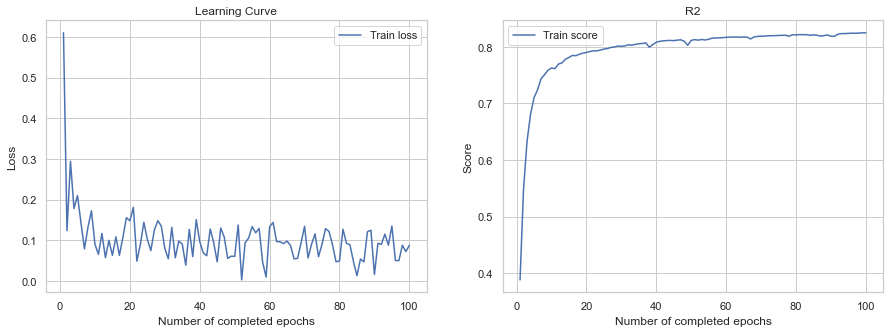

In [10]:
from src.modelling.linreg import SGD_linreg
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

'''X, z = create_dataset('../../data/raw/SRTM_data_Norway_1.tif',degree=5)
X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2) 
X_scl = StandardScaler().fit(X_train)
z_scl = StandardScaler().fit(z_train)
X_train = X_scl.transform(X_train)
X_test = X_scl.transform(X_test)
z_train = z_scl.transform(z_train)
z_test = z_scl.transform(z_test)'''

#OLS
ols =LinReg(regularization = None).fit(X_train,z_train)
ridge = LinReg(regularization = 'l2', lmb = lmb).fit(X_train,z_train)
#Predict test and train
z_tilde_ols = ols.predict(X_train)
z_pred_ols = ols.predict(X_test)
z_tilde_ridge = ridge.predict(X_train)
z_pred_ridge = ridge.predict(X_test)
#Score the models
train_mse_ols, train_r2_ols = MSE_R2(z_train,z_tilde_ols)
test_mse_ols, test_r2_ols = MSE_R2(z_test ,z_pred_ols)
train_mse_ridge, train_r2_ridge = MSE_R2(z_train,z_tilde_ridge)
test_mse_ridge, test_r2_ridge = MSE_R2(z_test ,z_pred_ridge)
#Printing the scores
print('OLS train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS test[MSE,R2]:',(test_mse_ols, test_r2_ols))
print('Ridge train[MSE,R2]:',(train_mse_ridge, train_r2_ridge), '\nRidge test[MSE,R2]:',(test_mse_ridge, test_r2_ridge))

#SGD OLS
lmb = 0.01
lr0 = 0.01
batch_size = 64
n_epochs = 100
momentum = 0
val_fraction = 0
learning_schedule = 'constant'
#initialize SGD linreg
sgd_ols = SGD_linreg(regularization = None, 
                     momentum= momentum,
                     lr0=lr0,
                     schedule = learning_schedule,
                     batch_size = batch_size, 
                     n_epochs = n_epochs,
                     val_fraction = val_fraction
                     )
sgd_ridge = SGD_linreg(regularization = 'l2',lmb=lmb,
                       momentum= 0,
                       lr0=lr0,
                       schedule = learning_schedule,
                       batch_size = batch_size, 
                       n_epochs = n_epochs,
                       val_fraction=val_fraction
                       )

#Fit sgd optimizer
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Predict test and train
z_tilde_ols_sgd = sgd_ols.predict(X_train)
z_pred_ols_sgd = sgd_ols.predict(X_test)
z_tilde_ridge_sgd = sgd_ridge.predict(X_train)
z_pred_ridge_sgd = sgd_ridge.predict(X_test)
#Score the models
train_mse_ols_sgd, train_r2_ols_sgd = MSE_R2(z_train,z_tilde_ols_sgd)
test_mse_ols_sgd, test_r2_ols_sgd = MSE_R2(z_test ,z_pred_ols_sgd)
train_mse_ridge_sgd, train_r2_ridge_sgd = MSE_R2(z_train,z_tilde_ols_sgd)
test_mse_ridge_sgd, test_r2_ridge_sgd = MSE_R2(z_test ,z_pred_ols_sgd)
#Printing the scores
print('OLS SGD train[MSE,R2]:',(train_mse_ols_sgd, train_r2_ols_sgd), 
      '\nOLS SGD test[MSE,R2]:',(test_mse_ols, test_r2_ols_sgd))
print('Ridge SGD train[MSE,R2]:',(train_mse_ridge_sgd, train_r2_ridge_sgd), 
      '\nRidge SGD test[MSE,R2]:',(test_mse_ridge, test_r2_ridge_sgd))

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'

fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

It can be seen that the parameters resulting from the SGDs does have a way to go to reach the analytical solutions with regards to parameters. Note that since the cost functions(both with and without regularization) are convex, the sgd should converge to the analytical solution with enough epochs and low enough learning rate. 

It is clear that loss and score improves with increasing epochs. From the learning curve of OLS it can be observed that the loss curve is fluctuating a lot. This may be due to several reasons, high learning rate and low batch size might be some of them.

OLS and Ridge still has the better train and test scores, however, it does not take much to reach a somewhat good solution. It must be noted that a cross validation is to be performed before concluding.

#### Batch size
The batch size determines the size of each mini batch the optimizer trains on for each sgd step. When training, the optimizer will run through n_batches=n_samples/batch_size, thereby still training using n_samples datapoints. As such, a smaller batch size causes more sgd steps while a bigger cause fewer.

<AxesSubplot:title={'center':'Running time'}, xlabel='Batch size[number of samples]', ylabel='Time[s]'>

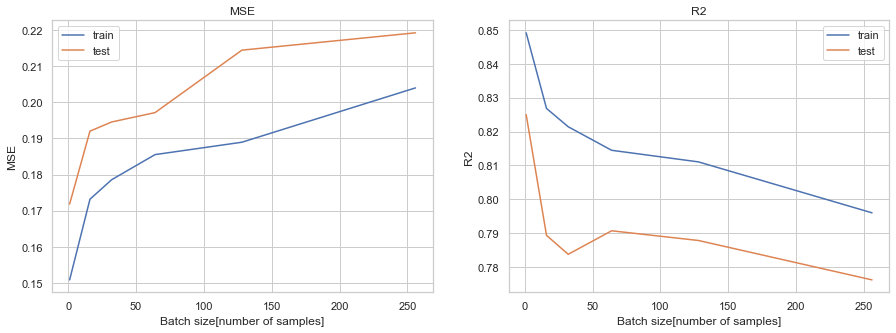

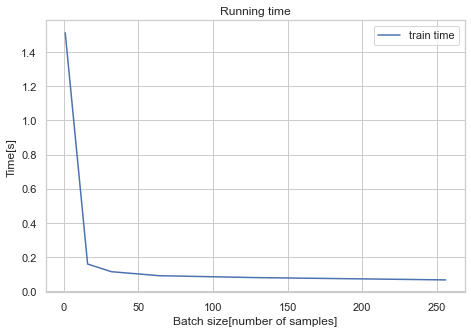

In [11]:
from src.model_evaluation.param_analysis import evaluate_parameter
from src.visualization.visualize import plot_curves

batch_sizes = np.array([1, 16, 32, 64, 128, 256])
sgd_ols.set_params(n_epochs=100)
scores = evaluate_parameter(sgd_ols,{'batch_size':batch_sizes},['MSE','R2'],X,z,X_scl,z_scl)

fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(15,5)
plot_curves(scores['MSE'],batch_sizes,('Batch size[number of samples]','MSE'),ax = ax1, title='MSE')
plot_curves(scores['R2'],batch_sizes,('Batch size[number of samples]','R2'),ax = ax2, title='R2')

fig,ax3 =plt.subplots()
fig.set_size_inches(7.5,5)
plot_curves({'train time':scores['train_time']},batch_sizes,('Batch size[number of samples]','Time[s]'),ax=ax3,title='Running time')

From the MSE and R2 plots one can observe that a low batch size leads to an improved loss and score of the model, and that increasing the batch size causes a poorer fit. Trom the running time plot it can be seen that it took substantially longer time to fit with low batch sizes. This is because the optimizer always uses n_samples amount of data points, however with bigger batch size, more of the data is included in the same matrix operation. Bigger matrix operation is faster than many smaller due to vectorization of code. As such, there seems to be a trade-off between running time and score when altering batch size.

Because batches contains consectutive data, using a bigger batch size increases the probability of a data point being included at some point in the training. As such, bigger batch sizes results in the use of more of the data. At the extreme, having a batch size equal to number of samples would lead to all data being used at each epoch. Intuitively, it would seem that a bigger batch size should result in a better fit as it uses more of the data. In fact, using the whole dataset as one batch guarantees convergence with enough epochs, however requires a lot more epochs to do so. In other words, one can achieve a good enough fit with a lower batch size, that does not require the same amount of epochs. Too low, however results in much slower running time and potentially a poorer fit. With more epochs, some of the above chosen batch sizes might perform better, but requires more running time.

As such, there should be a 'sweet spot' where the batch size is large enough to provide proper convergence but small enough to run sufficiently fast.
Higher batch size -> more epochs needed
Lower batch size -> more time on each epoch

#### Epochs
Number of epochs are number of times the optimizer iterates over it's batches. Increasing this would give the optimizer more 'time' to converge. Now increasing number of epochs to 1000.

OLS SGD train[MSE,R2]: (0.15586180550856604, 0.8441381944914339) 
OLS SGD test[MSE,R2]: (0.20732004295543588, 0.8121903445135763)
Ridge SGD train[MSE,R2]: (0.15608837231418354, 0.8439116276858164) 
Ridge SGD test[MSE,R2]: (0.2086717744272143, 0.8109658212190319)


,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,5.362968,0.253277,2.147676,0.259597
2,3.800074,0.039869,0.984145,0.035616
3,-22.585442,0.285311,-3.868789,0.279099
4,-6.766129,-0.154004,-3.061383,-0.148790
5,-20.355353,-0.051830,-1.642839,-0.050175
6,41.374459,0.140447,2.266572,0.133809
7,13.513663,0.293192,2.830074,0.288242
8,3.210312,-0.117163,-0.987492,-0.111299


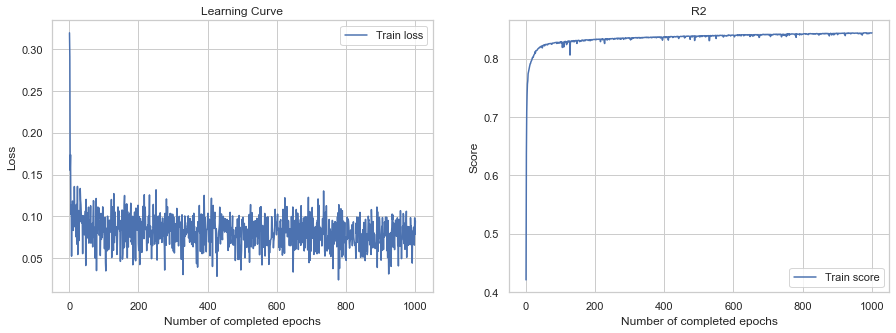

In [12]:
#Model parameters
lmb = 0.01
lr0 = 0.01
batch_size = 32
n_epochs = 1000 #Changing epochs to 1000
momentum = 0
learning_schedule = 'constant'

#Setting model parameters
sgd_ols.set_params(n_epochs=n_epochs,
                   batch_size=batch_size,
                   momentum = momentum,
                   lr0=lr0,
                   lmb=lmb,
                   schedule = learning_schedule)

sgd_ridge.set_params(n_epochs=n_epochs,
                     batch_size=batch_size,
                     momentum = momentum,
                     lr0= lr0,
                     lmb=lmb,
                     schedule = learning_schedule)

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Predict test and train
z_tilde_ols = sgd_ols.predict(X_train)
z_pred_ols = sgd_ols.predict(X_test)
z_tilde_ridge = sgd_ridge.predict(X_train)
z_pred_ridge = sgd_ridge.predict(X_test)
#Score the models
train_mse_ols, train_r2_ols = MSE_R2(z_train,z_tilde_ols)
test_mse_ols, test_r2_ols = MSE_R2(z_test ,z_pred_ols)
train_mse_ridge, train_r2_ridge = MSE_R2(z_train,z_tilde_ridge)
test_mse_ridge, test_r2_ridge = MSE_R2(z_test ,z_pred_ridge)
#Printing the scores
print('OLS SGD train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS SGD test[MSE,R2]:',(test_mse_ols, test_r2_ols))
print('Ridge SGD train[MSE,R2]:',(train_mse_ridge, train_r2_ridge), '\nRidge SGD test[MSE,R2]:',(test_mse_ridge, test_r2_ridge))

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'

fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

Loss and score are still somewhat improving upon termination, however much less. The parameters are still relatively different from the analytical ones. This may indicate that it doesn't take much to achieve score above 83-84%, but substantially harder to improve the latter 16-17%. Increasing the number of epochs may improve the results. Though, running this took about some time which doesn't exactly allow for quick prototyping. As a more complex design matrix and more data would lead to a lot longer running times, it's safe to say that the optimization method could benefit from running faster. 

<AxesSubplot:title={'center':'R2'}, xlabel='Number of completed epochs', ylabel='Score'>

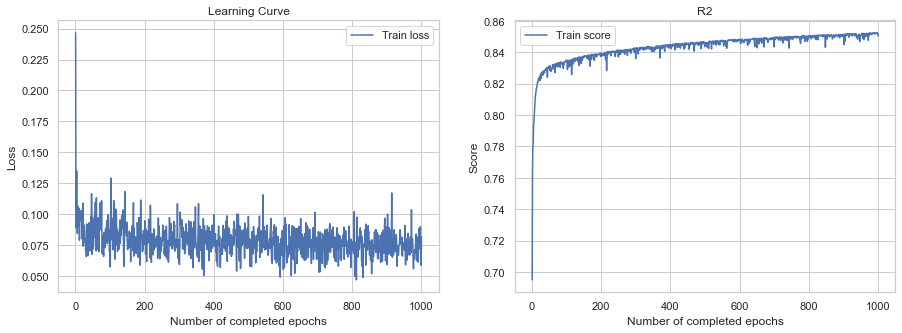

In [13]:
#Model parameters
lmb = 0.1
lr0 = 0.01
batch_size = 10 #Changing batch size to 10
n_epochs = 1000
momentum = 0
learning_schedule = 'constant'

#Setting model parameters
sgd_ols.set_params(n_epochs=n_epochs,
                   batch_size=batch_size,
                   momentum = momentum,
                   lr0=lr0,
                   lmb=lmb,
                   schedule = learning_schedule)

sgd_ridge.set_params(n_epochs=n_epochs,
                     batch_size=batch_size,
                     momentum = momentum,
                     lr0= lr0,
                     lmb=lmb,
                     schedule = learning_schedule)

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'

fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)

The plots above confirms that too low batch size is less able to converge properly. As the loss curve becomes flatter, it starts to fluctuate in both with 32 and 10 batch size. However, the R2 score is more flucuating with batch size 10. This may be because low batch sizes leads to many more different batches to choose from at each iteration. As such, the gradients may in turn vary a lot causing the noisy curves seen above. It may also indicate that it bounces around the optimal solution never being able to hit it properly, never within some distance from it. 

A batch size of 32 is used in further analysis.


#### Momentum
Momentum can be used to achieve faster convergence(i.e fewer epochs are needed for similar results). When using momentum during sgd optimization, we are in essence keeping track of a moving avergage and adding it on every sgd step. Moving average is often used to smooth noisy curves as consistent changes affect the average much more than noise. In the same way, using momentum allows the optimization to be less sensitive to sudden changes in the gradient. In other words, if a direction is consistently good to follow then sudden changes in the gradient will not affect the course very much. Unless of course, the change starts to become consitent.
The 'momentum' parameter specifies the amount of the moving average we're adding on each iteration. We are using momentum=0.9 which is a rather standard value.

100
OLS SGD train[MSE,R2]: (0.13943981545326953, 0.8605601845467304) 
OLS SGD test[MSE,R2]: (0.17049306831054356, 0.8455516217064003)
Ridge SGD train[MSE,R2]: (0.13943981545326953, 0.8605601845467304) 
Ridge SGD test[MSE,R2]: (0.17049306831054356, 0.8455516217064003)
SKlearn SGD train[MSE,R2]: (0.920430892578771, 0.07956910742122891) 
SKlearn SGD  test[MSE,R2]: (1.0782093428160553, 0.023258328862808875)


,OLS,OLS SGD,Ridge,Ridge SGD,Sklearn SGD
β,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.362968,0.467614,0.114382,0.069101,0.007270
2,3.800074,0.190318,-0.033188,-0.011730,-0.002334
3,-22.585442,0.094663,0.085714,0.063577,0.009034
4,-6.766129,-1.007813,0.078518,0.054677,0.001442
5,-20.355353,-0.052266,-0.046609,-0.019788,-0.003296
6,41.374459,0.265027,0.057045,0.055273,0.010241
7,13.513663,0.849991,0.096338,0.067642,0.003096
8,3.210312,-0.463751,0.058233,0.039519,-0.001387


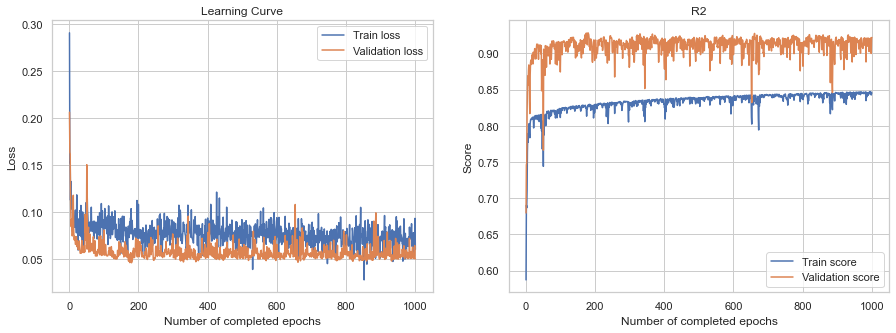

In [31]:
from sklearn.linear_model import SGDRegressor
#Model parameters
lmb = 100
lr0 = 0.01
batch_size = 32
n_epochs = 1000 
momentum = 0.9 #Adding 0.9 momentum to the optimizer
learning_schedule = 'constant'

#Setting model parameters
sgd_ols.set_params(n_epochs=n_epochs,
                   batch_size=batch_size,
                   momentum = momentum,
                   lr0= lr0,
                   lmb=lmb,
                   schedule = learning_schedule,
                   val_fraction = 0.1)

sgd_ridge.set_params(n_epochs=n_epochs,
                     batch_size=batch_size,
                     momentum = momentum,
                     lr0= lr0,
                     lmb=lmb,
                     schedule = learning_schedule,
                     val_fraction = 0.1)
print(sgd_ridge.lmb)
#Fit sk learn model for comparison
sgd_sk = SGDRegressor(fit_intercept = False, 
                      max_iter = n_epochs, 
                      penalty='l2',
                      alpha = lmb,
                      eta0 = lr0,
                      learning_rate=learning_schedule,
                      tol=None)

ridge = LinReg(regularization = 'l2',lmb=lmb)
ridge.fit(X_train, z_train)
#Fit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)
sgd_sk.fit(X_train,z_train.ravel())


#Predict test and train
z_tilde_ols_sgd = sgd_ols.predict(X_train)
z_pred_ols_sgd = sgd_ols.predict(X_test)
z_tilde_ridge_sgd = sgd_ridge.predict(X_train)
z_pred_ridge_sgd = sgd_ridge.predict(X_test)
z_tilde_sk = sgd_sk.predict(X_train)
z_pred_sk = sgd_sk.predict(X_test)
#Score the models
train_mse_ols, train_r2_ols = MSE_R2(z_train,z_tilde_ols_sgd)
test_mse_ols, test_r2_ols = MSE_R2(z_test ,z_pred_ols_sgd)
train_mse_ridge, train_r2_ridge = MSE_R2(z_train,z_tilde_ols_sgd)
test_mse_ridge, test_r2_ridge = MSE_R2(z_test ,z_pred_ols_sgd)
train_mse_sk, train_r2_sk = MSE_R2(z_train,z_tilde_sk.reshape(-1,1))
test_mse_sk, test_r2_sk = MSE_R2(z_test ,z_pred_sk.reshape(-1,1))
#Printing the scores

#Printing the scores
print('OLS SGD train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS SGD test[MSE,R2]:',(test_mse_ols, test_r2_ols))
print('Ridge SGD train[MSE,R2]:',(train_mse_ridge, train_r2_ridge), '\nRidge SGD test[MSE,R2]:',(test_mse_ridge, test_r2_ridge))
print('SKlearn SGD train[MSE,R2]:',(train_mse_sk, train_r2_sk), '\nSKlearn SGD  test[MSE,R2]:',(test_mse_sk, test_r2_sk))

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta,sgd_sk.coef_.T)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD','Sklearn SGD'])
df.index.name = 'β'
fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

As can be seen the parameters are getting even closer with the same amount of epochs. It can also be noted that the Sklearn method's resluting parameters looks somewhat more developed, at least the first few, than manually developed code. This is likely because it employs legacy sgd, where the gradient is estimated at each sample. I.e it does not use a certain batch size. As previously obtained resluts indicates that the optimizer may converge faster with lower batch sizes, this makes sense. Sklearn applies several algorithmic techniques to speed up their algorithm. Sklearn with batch size, would likely run even faster.

What is interesting, however, is that even though the manually written code does not reach the same parameters, it scores better on test than normal regression, and is not too far away from sklearn. It may be that sklearn have not actually converged much more than the own code, its parameters simply fluctuates between higher values at each sgd step. This may indicate that an sgd optimization not fully converged is perhaps better at generalizing. By monitoring the validation loss as well, it can be observed that it still increases with the train score, indicating that the model is not overfitting. Note that the model might still have overfit with regards to the test data.

#### Learning rate
Increasing the learning rate will make the sgd optimizer take a "bigger" step on each iteration and may in turn result in faster convergence. However, if the learning rate is too high, the optimization might overshoot and miss the target(being the optimal solution) and possibly diverge.

OLS SGD train[MSE,R2]: (0.2866844451047709, 0.7133155548952292) 
OLS SGD test[MSE,R2]: (0.16665811824789792, 0.824270807107856)
Ridge SGD train[MSE,R2]: (0.2866844451047709, 0.7133155548952292) 
Ridge SGD test[MSE,R2]: (0.16665811824789792, 0.824270807107856)


,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,5.514292,1.802095,2.132783,1.184240
2,2.977148,1.120614,0.900189,0.479434
3,-23.242133,-2.121117,-3.298591,-1.050124
4,-6.478229,-3.737934,-3.178632,-2.572666
5,-15.186446,-1.175411,-1.353633,-0.214581
6,44.367709,0.978570,1.996946,0.509952
7,12.529089,2.105720,2.521701,1.581063
8,3.253292,-0.356432,-0.827157,-0.469739


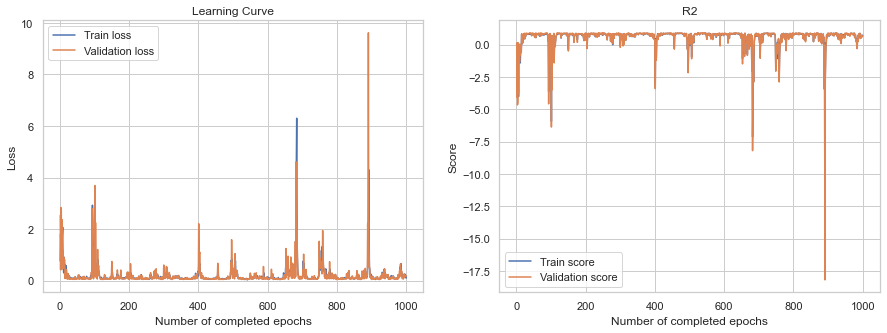

In [74]:
#Model parameters
lmb = 0.01
lr0 = 0.1 #Changing learning rate to 0.1
batch_size = 32
n_epochs = 1000 
momentum = 0.9
learning_schedule = 'constant'

#Setting model parameters
sgd_ols.set_params(n_epochs=n_epochs,
                   batch_size=batch_size,
                   momentum = momentum,
                   lr0=lr0,
                   lmb=lmb,
                   schedule = learning_schedule,
                   val_fraction = 0.1)

sgd_ridge.set_params(n_epochs=n_epochs,
                     batch_size=batch_size,
                     momentum = momentum,
                     lr0= lr0,
                     lmb=lmb,
                     schedule = learning_schedule,
                     val_fraction = 0.1)

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Predict test and train
z_tilde_ols_sgd = sgd_ols.predict(X_train)
z_pred_ols_sgd = sgd_ols.predict(X_test)
z_tilde_ridge_sgd = sgd_ridge.predict(X_train)
z_pred_ridge_sgd = sgd_ridge.predict(X_test)

#Score the models
train_mse_ols, train_r2_ols = MSE_R2(z_train,z_tilde_ols_sgd)
test_mse_ols, test_r2_ols = MSE_R2(z_test ,z_pred_ols_sgd)
train_mse_ridge, train_r2_ridge = MSE_R2(z_train,z_tilde_ols_sgd)
test_mse_ridge, test_r2_ridge = MSE_R2(z_test ,z_pred_ols_sgd)

#Printing the scores
print('OLS SGD train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS SGD test[MSE,R2]:',(test_mse_ols, test_r2_ols))
print('Ridge SGD train[MSE,R2]:',(train_mse_ridge, train_r2_ridge), '\nRidge SGD test[MSE,R2]:',(test_mse_ridge, test_r2_ridge))

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'
fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

Even though the final scores are not disatrous, the learning curves shows that that model has missed a lot before being able to converge. The learning curves have these sudden spikes during training. This may indicate that the optimizer has overshot the optimal solution, but was able to reel itself in. In any case, the scores are lower with this learning rate, which may indicate it does not converge properly.

What is interesting is that it still scores somewhat good on test set, but poor on train. This high learning rate might cause it to generalize much more. Although, it might very well be coincidental, that the test set simply contains samples that this model could predict with more ease.

c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
../..\src\model_evaluation\metrics.py:16: RuntimeWarning: overflow encountered in square
  return ((target-prediction)**2).mean()
../..\src\model_evaluation\metrics.py:8: RuntimeWarning: overflow encountered in square
  return 1 - sum((target - prediction) ** 2) / sum((target - mean(target)) ** 2)
../..\src\modelling\linreg.py:406: RuntimeWarning: overflow encountered in matmul
  grad = (1/X.shape[0])*(X.T @ update)
../..\src\modelling\linreg.py:309: RuntimeWarning: invalid value encountered in matmul
  return X @ self.beta + self.intercept
../..\src\modelling\linreg.py:406: RuntimeWarni

../..\src\model_evaluation\metrics.py:16: RuntimeWarning: overflow encountered in square
  return ((target-prediction)**2).mean()
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
../..\src\model_evaluation\metrics.py:8: RuntimeWarning: overflow encountered in square
  return 1 - sum((target - prediction) ** 2) / sum((target - mean(target)) ** 2)
../..\src\modelling\linreg.py:406: RuntimeWarning: overflow encountered in matmul
  grad = (1/X.shape[0])*(X.T @ update)
../..\src\modelling\linreg.py:309: RuntimeWarning: invalid value encountered in matmul
  return X @ self.beta + self.intercept
../..\src\modelling\linreg.py:406: RuntimeWarning: invalid value encountered in matmul
  grad = (1/X.shape[0])*(X.T @ update)


<AxesSubplot:title={'center':'R2'}, xlabel='Learning rate(constant)', ylabel='R2'>

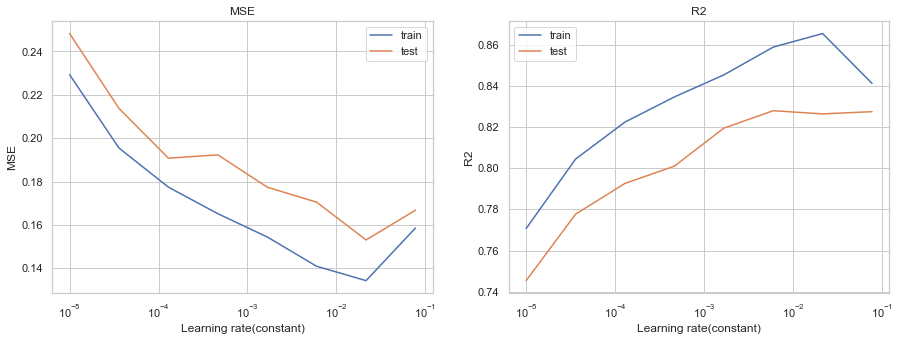

In [53]:
#Model parameters
lmb = 0.01
batch_size = 32
n_epochs = 1000 
momentum = 0.9
learning_schedule = 'constant'

#Setting model parameters
sgd_ols.set_params(n_epochs=n_epochs,
                   batch_size=batch_size,
                   momentum = momentum,
                   lr0=lr0,
                   lmb=lmb,
                   schedule = learning_schedule)

lrs = np.logspace(-5, 0, 10)

scores = evaluate_parameter(sgd_ols,{'lr0':lrs},['MSE','R2'],X,z,X_scl,z_scl)

fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(15,5)
plot_curves(scores['MSE'],lrs,('Learning rate(constant)','MSE'),ax = ax1, title='MSE',x_axis='semilog')
plot_curves(scores['R2'],lrs,('Learning rate(constant)','R2'),ax = ax2, title='R2',x_axis='semilog')

From above plots it can be understood that increasing the learning rate up to a certain point may improve the fit. Too low learning rate hinders the optimizer in converging. Too high, causes it to bounce around the solution. And even higher causes divergence. Note that the optimizer is encoutering overflow when learning rate is above 0.1.

#### Learning schedule
By applying a decaying learning rate schedule, the learning rate will decrease with increasing epochs. This can possibly mitigate the flucutations around the solution that may happen with high constant learning rates and can also allow for higher initial learning rates without causing overflow and divergence.


OLS SGD train[MSE,R2]: (0.16275534758773477, 0.8372446524122653) 
OLS SGD test[MSE,R2]: (0.13952832118217834, 0.8528772583975262)
Ridge SGD train[MSE,R2]: (0.16275534758773477, 0.8372446524122653) 
Ridge SGD test[MSE,R2]: (0.13952832118217834, 0.8528772583975262)


,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,5.514292,0.354838,2.132783,0.207475
2,2.977148,0.135849,0.900189,0.007141
3,-23.242133,0.297111,-3.298591,0.262933
4,-6.478229,-0.163175,-3.178632,-0.127594
5,-15.186446,-0.102865,-1.353633,-0.018429
6,44.367709,0.124205,1.996946,0.130887
7,12.529089,0.219841,2.521701,0.276660
8,3.253292,-0.157289,-0.827157,-0.102557


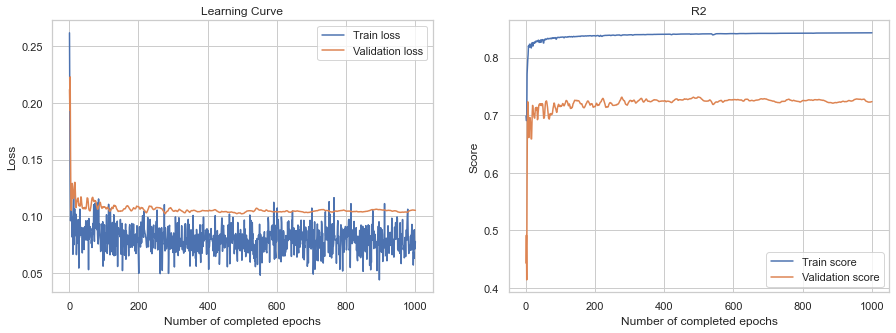

In [75]:
#Model parameters
lmb = 0.1
lr0 = 0.01 
batch_size = 32
n_epochs = 1000 
momentum = 0.9
learning_schedule = 'decaying'

#Setting model parameters
sgd_ols.set_params(n_epochs=n_epochs,
                   batch_size=batch_size,
                   momentum = momentum,
                   lmb=lmb,
                   lr0=lr0,
                   schedule = learning_schedule)

sgd_ridge.set_params(n_epochs=n_epochs,
                     batch_size=batch_size,
                     momentum = momentum,
                     lr0= lr0,
                     lmb=lmb,
                     schedule = learning_schedule)

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Predict test and train
z_tilde_ols_sgd = sgd_ols.predict(X_train)
z_pred_ols_sgd = sgd_ols.predict(X_test)
z_tilde_ridge_sgd = sgd_ridge.predict(X_train)
z_pred_ridge_sgd = sgd_ridge.predict(X_test)

#Score the models
train_mse_ols, train_r2_ols = MSE_R2(z_train,z_tilde_ols_sgd)
test_mse_ols, test_r2_ols = MSE_R2(z_test ,z_pred_ols_sgd)
train_mse_ridge, train_r2_ridge = MSE_R2(z_train,z_tilde_ols_sgd)
test_mse_ridge, test_r2_ridge = MSE_R2(z_test ,z_pred_ols_sgd)

#Printing the scores
print('OLS SGD train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS SGD test[MSE,R2]:',(test_mse_ols, test_r2_ols))
print('Ridge SGD train[MSE,R2]:',(train_mse_ridge, train_r2_ridge), '\nRidge SGD test[MSE,R2]:',(test_mse_ridge, test_r2_ridge))

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'
fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

It is clear that with a decaying learning rate, the score fluctuates much less. From the loss curve it can be observed that the solution takes a big leap in the beginning reaching a low loss early, though it is unclear as the first loss is very big compared to the rest. It does stagnates somewhat which may be because the learning rate decays too much. There are likely other settings for the decaying learning rate that may improve the fit, however will not be explored furhter.

A quick test using a larger learning rate with a larger batch size is also tested. As stated above, larger batch sizes should be better at converging.

OLS SGD train[MSE,R2]: (0.13070443586392633, 0.8692955641360738) 
OLS SGD test[MSE,R2]: (0.12816737569564807, 0.8648565715076739)
Ridge SGD train[MSE,R2]: (0.13070443586392633, 0.8692955641360738) 
Ridge SGD test[MSE,R2]: (0.12816737569564807, 0.8648565715076739)


,OLS,OLS SGD,Ridge,Ridge SGD
β,,,,
0,0.000000,0.000000,0.000000,0.000000
1,5.514292,0.804671,2.132783,0.692725
2,2.977148,0.492305,0.900189,0.218602
3,-23.242133,-0.160816,-3.298591,-0.008338
4,-6.478229,-1.855389,-3.178632,-1.242761
5,-15.186446,-0.287363,-1.353633,-0.067720
6,44.367709,0.430306,1.996946,0.181494
7,12.529089,1.209537,2.521701,0.954897
8,3.253292,-0.558856,-0.827157,-0.366178


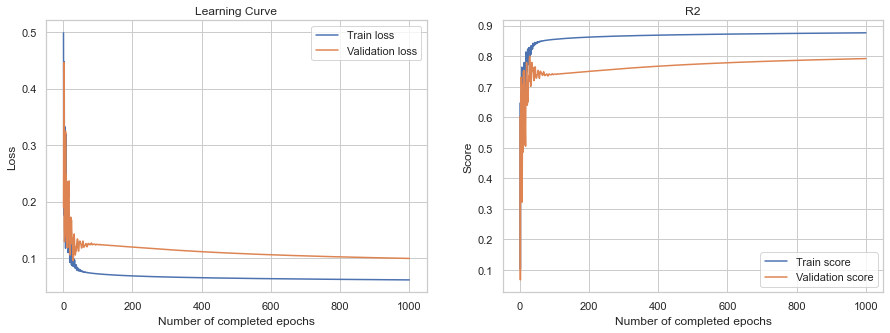

In [76]:
#Model parameters
lmb = 0.1
lr0 = 0.1 
batch_size = 512
n_epochs = 1000 
momentum = 0.9
learning_schedule = 'constant'

#Setting model parameters
sgd_ols.set_params(n_epochs=n_epochs,
                   batch_size=batch_size,
                   momentum = momentum,
                   lmb=lmb,
                   lr0=lr0,
                   schedule = learning_schedule)

sgd_ridge.set_params(n_epochs=n_epochs,
                     batch_size=batch_size,
                     momentum = momentum,
                     lr0= lr0,
                     lmb=lmb,
                     schedule = learning_schedule)

#Refit the models
sgd_ols.fit(X_train,z_train)
sgd_ridge.fit(X_train,z_train)

#Predict test and train
z_tilde_ols_sgd = sgd_ols.predict(X_train)
z_pred_ols_sgd = sgd_ols.predict(X_test)
z_tilde_ridge_sgd = sgd_ridge.predict(X_train)
z_pred_ridge_sgd = sgd_ridge.predict(X_test)

#Score the models
train_mse_ols, train_r2_ols = MSE_R2(z_train,z_tilde_ols_sgd)
test_mse_ols, test_r2_ols = MSE_R2(z_test ,z_pred_ols_sgd)
train_mse_ridge, train_r2_ridge = MSE_R2(z_train,z_tilde_ols_sgd)
test_mse_ridge, test_r2_ridge = MSE_R2(z_test ,z_pred_ols_sgd)

#Printing the scores
print('OLS SGD train[MSE,R2]:',(train_mse_ols, train_r2_ols), '\nOLS SGD test[MSE,R2]:',(test_mse_ols, test_r2_ols))
print('Ridge SGD train[MSE,R2]:',(train_mse_ridge, train_r2_ridge), '\nRidge SGD test[MSE,R2]:',(test_mse_ridge, test_r2_ridge))

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,ridge.beta,sgd_ridge.beta)),
                  columns=['OLS','OLS SGD', 'Ridge','Ridge SGD'])
df.index.name = 'β'
fig,(ax1,ax2) =plt.subplots(1,2)
fig.set_size_inches(15,5)
sgd_ols.plot_loss('Learning Curve',ax1)
sgd_ols.plot_score('R2',ax2)
df

A high batch size cause less fluctuations, but as can be seen from the loss curve, a higher initial loss. With such a high learning rate as 0.1 it is able to learn rather quickly. It is clear that there is a relationship between learning rate and batch size. A larger batch size may allow higher learning rates without the same amount of fluctuations however may still require more epochs to converge.

It must be noted that the resulting parameters are still somewhat different from the analytical ones. As the cost function is convex, the sgd version should converge to the analytical solution with enough epochs. An sgd model stopping before the analytical parameters are reached, may be enough, if not better than the fully converged solution.

Going forward a constant learning rate of 0.01 will be employed together with batch size 32.

#### Lambda
The regularization works in the same manner as with Ridge. It dampens the parameters and puts a certain constraint to them. At every sgd step the beta is updated as such:

$
\beta_i = (1-\lambda)\beta_{i-1} - \nabla E
$

where $\nabla E\$ is the same gradient used when L2 is not employed. As such, the update first reduces the parameters (1-lmb) of the former parameters, then substracts the gradient. And thus, it reduces larger parameters more than smaller, with regards to the absolute value. It's like a constant tug of war between itself and the gradient changing it. In one iteration, the former beta might be small but the new gradient is large. This cause a big change to beta, however, in the next iteration the beta will become smaller again due to it's former large values. It does not mean that, if running many many epochs beyond convergence the beta values would continue to fade out, because at this point the gradients will start becoming large again.



#### Tuning lr and lambda
A common first step when tuning a model using regularization is to find a satisfactory combination of learing rate and lambda. This is because a certain learning rate can work well with some values of lambda, but not others, and vice versa. This is indeed the case for most parameters, but perhaps more so with lr and lambda. The reason is that a large lr may cause large gradients and big changes to the parameters, while the regularization will subtract a portion of the parameter values at each update effectively punishing big changes.

One method to obtain a suitable combination of the parameters is to perform a gridsearch. Here two arrays of lambdas and learing rates are created. These contains the values one whishes to test. All models written in this project is implemented to work with SKlearn's GridSearch, as it provides efficient parallelization.

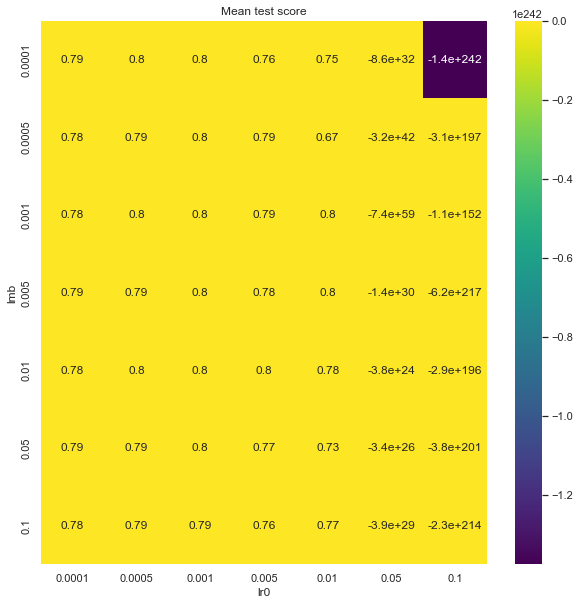

lmb                0.001000
lr0                0.001000
mean_test_score    0.801391
rank_test_score           1
Name: 16, dtype: object


In [78]:
from src.model_evaluation.param_analysis import grid_search_df
from src.visualization.visualize import plot_grid_search

lambdas = np.asarray([0.0001,0.0005,0.001,0.005,0.01,0.05,0.1])
lrs = np.asarray([0.0001,0.0005,0.001,0.005,0.01,0.05,0.1])

#Model parameters
lmb = 0.01
lr0 = 0.01
batch_size = 32
n_epochs = 1000 
momentum = 0.9 
learning_schedule = 'constant'

sgd_ridge.set_params(n_epochs=n_epochs,
                     batch_size=batch_size,
                     momentum = momentum,
                     lr0= lr0,
                     lmb=lmb,
                     schedule = learning_schedule)

best_model, scores = grid_search_df(X_train,z_train,sgd_ridge, param_grid=dict(lmb=lambdas,lr0=lrs))
plot_grid_search(scores,('lmb','lr0'))
print(scores.loc[scores['rank_test_score'].idxmin()])

From the gridsearch results it can be seen that lmb = 0.001 and lr = 0.001 yielded the best test score.

## Benchmarkin
The SGD regression with and without L2 penalization is compare to Ridge and OLS respectively.


### Comparing SGD regression without L2 to OLS

In [87]:
#Model parameters
lmb = 0.001
lr0 = 0.01 
batch_size = 32
n_epochs = 1000
momentum = 0.9
learning_schedule = 'constant'

#Setting model parameters
sgd_ols.set_params(n_epochs=n_epochs,
                   batch_size=batch_size,
                   momentum = momentum,
                   lmb=lmb,
                   lr0 = lr0,
                   schedule = learning_schedule)

#Refit the models
sgd_ols.fit(X_train,z_train)

#Fit sk learn model for comparison
sgd_sk = SGDRegressor(fit_intercept = False, 
                      max_iter = n_epochs, 
                      penalty=None, 
                      eta0 = lr0,
                      learning_rate='constant',
                      tol=None)
sgd_sk.fit(X_train,z_train.ravel())

#OLS
ols = LinReg(regularization = None).fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ols.beta,sgd_ols.beta,sgd_sk.coef_.T)),
                  columns=['OLS','OLS SGD', 'OLS SGD sklearn'])
df.index.name = 'β'

own_ols_scores = cross_val_score(ols,X,z,5,X_scl,z_scl,['MSE','R2'])
own_sgd_scores = cross_val_score(sgd_ols,X,z,5,X_scl,z_scl,['MSE','R2'])
sk_scores = cross_val_score(sgd_sk,X,z.ravel(),5,X_scl,z_scl,['MSE','R2'])

print('CV results:\n')
print('OLS train[MSE,R2]:',(own_ols_scores['train']['MSE'], own_ols_scores['train']['R2']), '\nOLS test[MSE,R2]:',(own_ols_scores['test']['MSE'], own_ols_scores['test']['R2']))
print('Own SGD train[MSE,R2]:',(own_sgd_scores['train']['MSE'], own_sgd_scores['train']['R2']), '\nOwn SGD test[MSE,R2]:',(own_sgd_scores['test']['MSE'], own_sgd_scores['test']['R2']))
print('Sk SGD train[MSE,R2]:',(sk_scores['train']['MSE'], sk_scores['train']['R2']), '\nSk SGD test[MSE,R2]:',(sk_scores['test']['MSE'], sk_scores['test']['R2']))

df


CV results:

OLS train[MSE,R2]: (0.09689181903549335, 0.9031081809645066) 
OLS test[MSE,R2]: (0.13613762603256185, 0.8502872859608235)
Own SGD train[MSE,R2]: (0.14055038626107014, 0.8594496137389299) 
Own SGD test[MSE,R2]: (0.16994432324421258, 0.8249567071535543)
Sk SGD train[MSE,R2]: (0.13367157238953817, 0.8663284276104619) 
Sk SGD test[MSE,R2]: (0.15291601192331616, 0.8403527746225194)


c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\oliver\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A col

,OLS,OLS SGD,OLS SGD sklearn
β,,,
0,0.000000,0.000000,0.000000
1,5.514292,0.623418,1.164049
2,2.977148,0.285952,0.446809
3,-23.242133,0.247643,-0.632973
4,-6.478229,-1.296692,-2.379320
5,-15.186446,0.083577,-0.081954
6,44.367709,0.242703,0.352442
7,12.529089,0.821462,1.590722
8,3.253292,-0.430643,-0.527191


From the cv results it can be seen that the regular OLS still outperforms both models in terms of train and test. There is a bigger discrepancy between train and test score on OLS than for own SGD and sklearn SGD, which  may indicate that SGD is a more "general" approach.

<Axes3DSubplot:title={'center':'SGD sklearn'}, xlabel='X', ylabel='Y'>

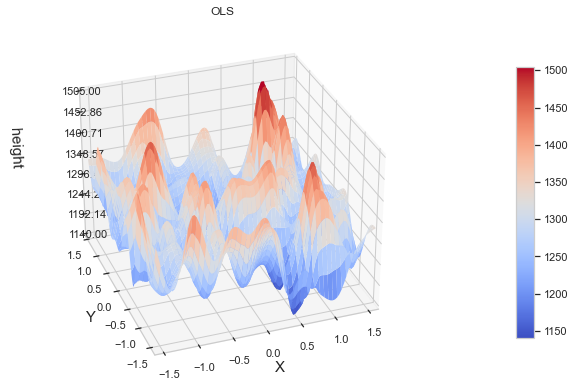

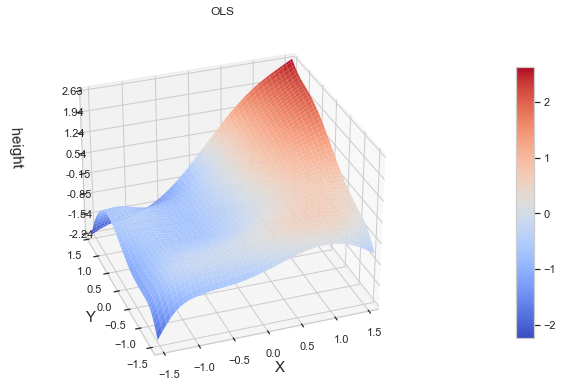

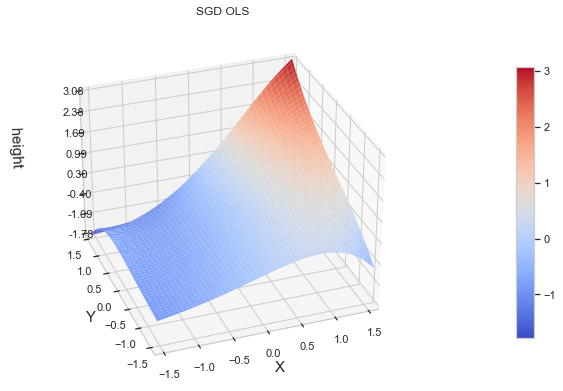

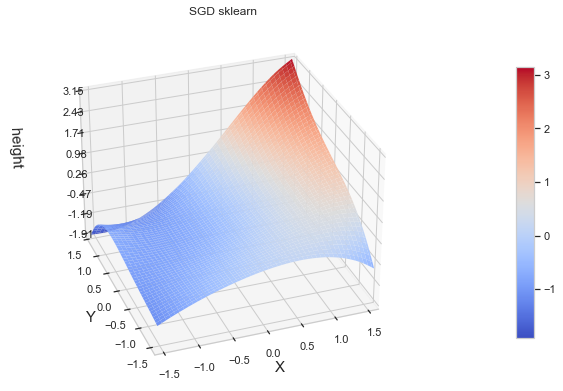

In [89]:
tilde_ols = ols.predict(X_train)
tilde_sgd = sgd_ols.predict(X_train)
tilde_sk = sgd_sk.predict(X_train)
pred_ols = ols.predict(X_test)
pred_sgd = sgd_ols.predict(X_test)
pred_sk = sgd_sk.predict(X_test)

X_ = np.concatenate((X_train,X_test))

plot_surf_from_X(X_,np.concatenate((tilde_ols,pred_ols)),'OLS')
plot_surf_from_X(X_,np.concatenate((tilde_sgd,pred_sgd)),'SGD OLS')
plot_surf_from_X(X_,np.concatenate((tilde_sk,pred_sk)),'SGD sklearn' )

From the surface plots it can be seen that all methods given enough epochs are able to construct convincing terrain map.

### Comparing SGD regression with L2 to Ridge

In [93]:
#Model parameters
lr0 =0.001
lmb = 0.001
batch_size = 32
n_epochs = 1000 
momentum = 0.9
learning_schedule = 'constant'

sgd_ridge.set_params(n_epochs=n_epochs,
                     batch_size=batch_size,
                     momentum = momentum,
                     lr0= lr0,
                     lmb=lmb,
                     schedule = learning_schedule)
#Refit the models
sgd_ridge.fit(X_train,z_train)

#Print parameters
df = pd.DataFrame(np.column_stack((ridge.beta,sgd_ridge.beta)),
                  columns=['Ridge','Ridge SGD'])
df.index.name = 'β'

own_ridge_scores = cross_val_score(ridge,X,z,5,X_scl,z_scl,['MSE','R2'])
own_sgd_scores = cross_val_score(sgd_ridge,X,z,5,X_scl,z_scl,['MSE','R2'])


print('CV results:\n')
print('Ridge train[MSE,R2]:',(own_ridge_scores['train']['MSE'], own_ridge_scores['train']['R2']), 
      '\nRidge test[MSE,R2]:',(own_ridge_scores['test']['MSE'], own_ridge_scores['test']['R2']))
print('Ridge SGD train[MSE,R2]:',(own_sgd_scores['train']['MSE'], own_sgd_scores['train']['R2']), 
      '\nRidge SGD test[MSE,R2]:',(own_sgd_scores['test']['MSE'], own_sgd_scores['test']['R2']))


df

CV results:

Ridge train[MSE,R2]: (0.1120895074277272, 0.8879104925722728) 
Ridge test[MSE,R2]: (0.1483392990132983, 0.8522748159271624)
Ridge SGD train[MSE,R2]: (0.15946543941938776, 0.8405345605806123) 
Ridge SGD test[MSE,R2]: (0.17890637075009927, 0.8078632701583087)


,Ridge,Ridge SGD
β,,
0,0.000000,0.000000
1,1.938301,0.352977
2,0.966385,0.097374
3,-2.071966,0.274310
4,-3.728620,-0.194828
5,-1.438140,-0.049177
6,0.695810,0.105856
7,3.457273,0.197000
8,-0.778492,-0.141325


Ridge with matrix inversion is also performing better than with SGD. Here there's also about the same discrepancy between train and test scores.

<Axes3DSubplot:title={'center':'Ridge OLS'}, xlabel='X', ylabel='Y'>

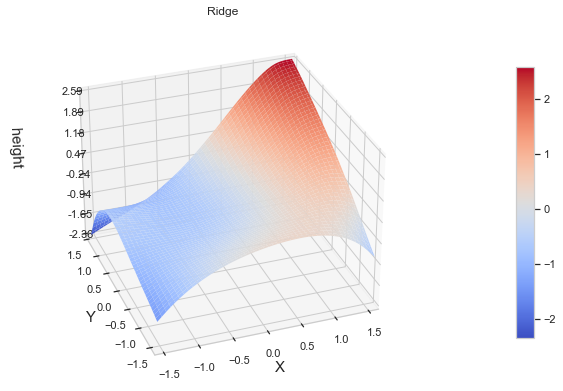

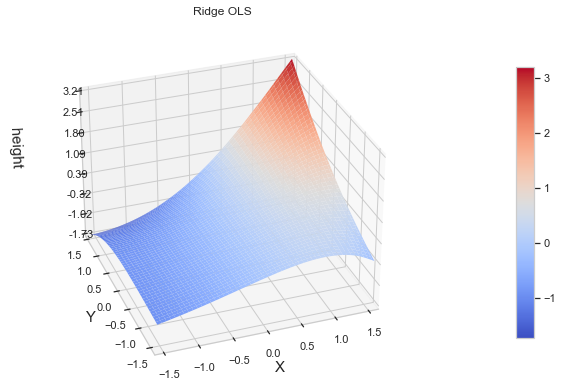

In [94]:
tilde_ridge = ridge.predict(X_train)
tilde_sgd = sgd_ridge.predict(X_train)
pred_ridge = ridge.predict(X_test)
pred_sgd = sgd_ridge.predict(X_test)


X_ = np.concatenate((X_train,X_test))

plot_surf_from_X(X_,np.concatenate((tilde_ridge,pred_ridge)),'Ridge')
plot_surf_from_X(X_,np.concatenate((tilde_sgd,pred_sgd)),'Ridge OLS')

From the surfaces it can be seen that the SGD produces a lot smoother surface than normal Ridge.